In [1]:
import galsim
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

## Example Spot

Sigma =  2.268686294555664
Flux =  51964.06640625
Shear =  galsim.Shear(g1=0.004121827543634817,g2=-0.002200752581091981)
Centroid =  galsim.PositionD(32.47609359004949,32.51878703853093)
13.994155452000696
Noise sigma =  5.638721417322094
RMS Noise =  5.713304286050135


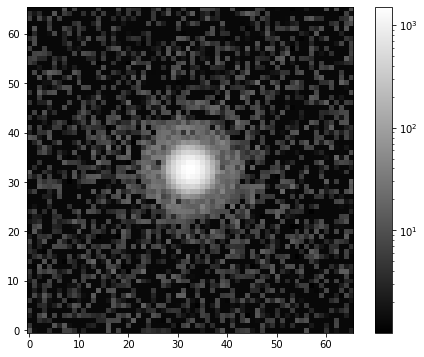

In [11]:
# random seed
rng = galsim.BaseDeviate(12345)

# model atmospheric turbulence as a VonKarman, with some small shear
gprof = galsim.VonKarman(lam=1000.,r0=0.2,L0=10.0).shear(g1=0.06, g2=-0.05)

# add 4.5 microns sigma of Gaussian to model diffusion
# convert 4.5 microns to arcsec with factor 0.2"/10micron 
pixscale = 0.2/10.e-6
dprof = galsim.Gaussian(sigma=9.0e-6*pixscale)

# Airy function to simulate diffraction through mask
lam_over_diam = 0.00000491  # radians
lam_over_diam *= 206265  # Convert to arcsec
airy = galsim.Airy(lam_over_diam)


# add optical term, making up reasonable Zernike terms
oprof = galsim.OpticalPSF(lam=700.0,diam=8.4,
                          defocus = 0.1,coma1 = -0.1, coma2 = 0.005, astig1 = 0.1, astig2 = 0.005,
                          obscuration = 0.4)

# add shear term
sprof = galsim.Shear(g1=0.05, g2=0.03)

# add foreground light in photons/cm^2/s, default exposure is applied in drawImage() = 1s
fprof = galsim.Box(100,100,flux=60000.0)

# convolve these terms
prof = galsim.Convolve([dprof,airy]).withFlux(60000.)
prof = galsim.Add([prof,fprof])


# draw image
blank_image = galsim.Image(66,66,scale=0.2,xmin=0,ymin=0,dtype=np.float64)  
star_image = prof.drawImage(image=blank_image,method='phot', save_photons=True)
    
sensor = galsim.SiliconSensor(strength = 1.0, diffusion_factor=100, nrecalc=1000)
photons = galsim.PhotonArray(60000)
sensor.accumulate(photons, star_image)

# generate noise and add to image
noise = galsim.CCDNoise(rng, gain=1.5, read_noise=8.2, sky_level=0.0)
star_image.addNoise(noise)

# calculate HSM moments (these are in pixel coordinates)
mom = star_image.FindAdaptiveMom(weight=None, strict=False)
print("Sigma = ",mom.moments_sigma)
print("Flux = ",mom.moments_amp)
print("Shear = ",mom.observed_shape)
print("Centroid = ",mom.moments_centroid)


# plot it
f,ax = plt.subplots(1,1, figsize=(8,6))
from matplotlib.colors import LogNorm
stamp = star_image.array
print(stamp[0,0])
print("Noise sigma = ", np.std(stamp[0:15,0:15]))
print("RMS Noise = ", np.sqrt(np.mean(stamp[0:15,0:15].flatten()**2)) )
stamp[stamp <= 1] = np.mean(stamp[0:10,0:10])
im = ax.imshow(star_image.array,origin='lower',interpolation='None', cmap="gray", norm=LogNorm())
f.colorbar(im,ax=ax)
#2.267101287841797

## Same spots with varying noise level

Text(0.5, 0, 'Read Noise [rms e-]')

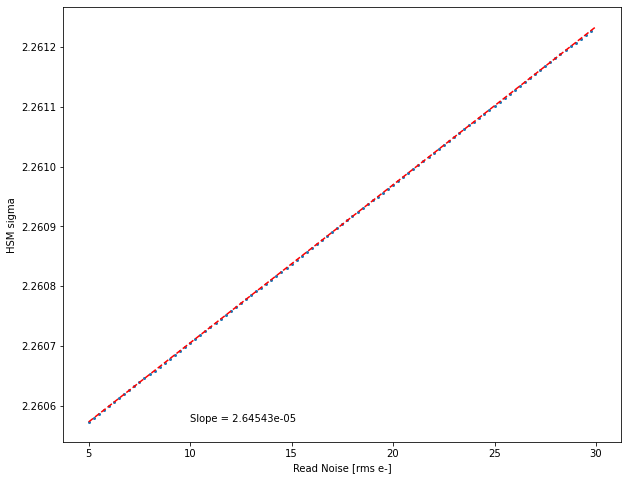

In [3]:
f,ax = plt.subplots(1,1, figsize=(10,8))

# generate multiple versions of the same star with added noise variation
stars = []
for i in range(100):

    # random seed
    rng = galsim.BaseDeviate(12345)

    # add 9.0 microns sigma of Gaussian to model diffusion
    # convert 9.0 microns to arcsec with factor 0.2"/10micron 
    pixscale = 0.2/10.e-6
    dprof = galsim.Gaussian(sigma=9.0e-6*pixscale)

    # Airy function to simulate diffraction through mask
    # Calculated from ~1000nm light and estimated distance to mask to match observed spots
    lam_over_diam = 0.00000491  # radians
    lam_over_diam *= 206265  # Convert to arcsec
    airy = galsim.Airy(lam_over_diam)

    # add shear term (optional)
    sprof = galsim.Shear(g1=0.05, g2=0.03)

    # add foreground light in photons/cm^2/s
    fprof = galsim.Box(66,66,flux=60000)

    # convolve these terms
    prof = galsim.Convolve([dprof,airy]).withFlux(8000.)
    prof = galsim.Add([prof,fprof])

    # draw image
    blank_image = galsim.Image(66,66,scale=0.2,xmin=0,ymin=0,dtype=np.float64)  
    star_image = prof.drawImage(image=blank_image,method='sb')

    # generate noise and add to image
    noise = galsim.CCDNoise(rng, gain=1.5, read_noise=5.+(0.25*i), sky_level=0.0)
    star_image.addNoise(noise)

    stars.append(star_image)

# generate multiple stars with different noise levels
moments_sigma = [] # sigma
moments_amp = [] # flux
observed_shape = [] # shear
moments_centroid = [] # centroid
peak_signal = [] # peak_signal
read_noise = [] # added CCD Noise

for i,star in enumerate(stars):
    # calculate HSM moments (these are in pixel coordinates) for each star
    mom = star.FindAdaptiveMom(weight=None, strict=False)
    moments_sigma.append(mom.moments_sigma)
    moments_amp.append(mom.moments_amp)
    observed_shape.append(mom.observed_shape.shear)
    moments_centroid.append(mom.moments_centroid)
    peak_signal.append(np.max(stars[i].array))
    read_noise.append(5.+(0.25*i))


# plot it
im = ax.scatter(read_noise,moments_sigma,s=4)
m,b = np.polyfit(read_noise,moments_sigma,deg=1)
plt.plot([5,30], [(5*m) + b, (30*m) + b], "r--")
plt.text(10, np.min(moments_sigma), "Slope = " + str(round(m,10)))
plt.ylabel("HSM sigma")
plt.xlabel("Read Noise [rms e-]")


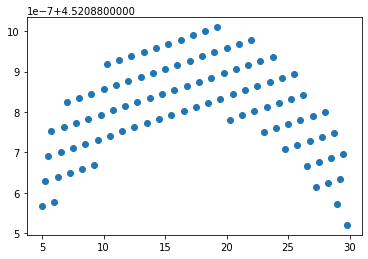

In [4]:
residuals = np.asarray(moments_sigma) - (np.asarray(read_noise) * m) + b
plt.scatter(read_noise, residuals)

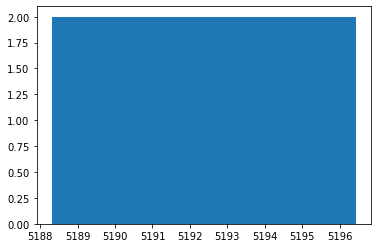

In [5]:
# distribution of peak signals
h = plt.hist(peak_signal, bins=50)

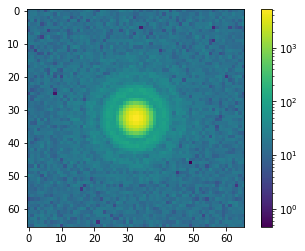

In [6]:
plt.imshow(stars[0].array, norm=LogNorm())
plt.colorbar()

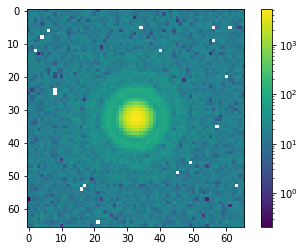

In [7]:
plt.imshow(stars[10].array, norm=LogNorm())
plt.colorbar()

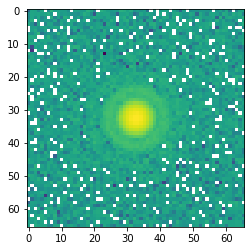

In [8]:
plt.imshow(stars[50].array, norm=LogNorm())

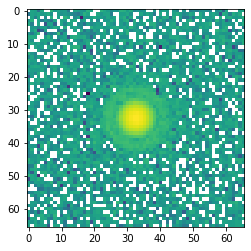

In [9]:
plt.imshow(stars[-1].array, norm=LogNorm())

## Different spots with same noise level

2.2748528321584067


Text(0.5, 0, 'Peak signal [e-]')

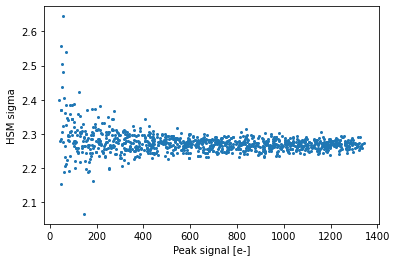

In [15]:
# generate multiple of the same star (stochastic variation)
stars = []
for i in range(1000):
    # random seed
    rng = galsim.BaseDeviate(i)

    # add 4.5 microns sigma of Gaussian to model diffusion
    # convert 4.5 microns to arcsec with factor 0.2"/10micron 
    pixscale = 0.2/10.e-6
    dprof = galsim.Gaussian(sigma=9.0e-6*pixscale)

    # Airy function to simulate diffraction through mask
    lam_over_diam = 0.00000491  # radians
    lam_over_diam *= 206265  # Convert to arcsec
    airy = galsim.Airy(lam_over_diam)


    # aadd shear term
    sprof = galsim.Shear(g1=0.05, g2=0.03)
    
    # add foreground light in photons/cm^2/s
    fprof = galsim.Box(66,66,flux=60000)

    # convolve these terms
    prof = galsim.Convolve([dprof,airy]).withFlux(1000. + 50.*i)
    prof = galsim.Add([prof,fprof])
    

    # draw image
    blank_image = galsim.Image(66,66,scale=0.2,xmin=0,ymin=0,dtype=np.float64)  
    star_image = prof.drawImage(image=blank_image,method='phot', save_photons=True)
    
    sensor = galsim.SiliconSensor(strength = 1.0, diffusion_factor=1, nrecalc=1000)
    photons = galsim.PhotonArray(int(1000. + 50.*i))
    sensor.accumulate(photons, star_image)

    # generate noise and add to image
    noise = galsim.CCDNoise(rng, gain=1.5, read_noise=11.3, sky_level=0.0)
    star_image.addNoise(noise)
    
    stars.append(star_image)

# generate multiple stars with different noise levels
moments_sigma = [] # sigma
moments_amp = [] # flux
observed_shape = [] # shear
moments_centroid = [] # centroid
peak_signal = []
read_noise = []

for i,star in enumerate(stars):
    # calculate HSM moments (these are in pixel coordinates) for each star
    mom = star.FindAdaptiveMom(weight=None, strict=False)
    moments_sigma.append(mom.moments_sigma)
    moments_amp.append(mom.moments_amp)
    observed_shape.append(mom.observed_shape)
    moments_centroid.append(mom.moments_centroid)
    peak_signal.append(np.max(stars[i].array))
    read_noise.append(11.3)

    
# plot it
f,ax = plt.subplots(1,1)
print(np.mean(moments_sigma[-10:-1]))
im = ax.scatter(peak_signal,moments_sigma, s=4)
plt.ylabel("HSM sigma")
plt.xlabel("Peak signal [e-]")
# 2.2523091634114585

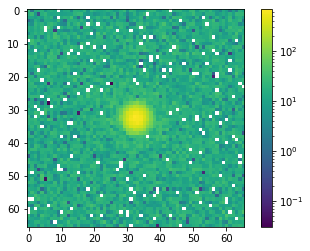

In [11]:
plt.imshow(stars[0].array, norm=LogNorm())
plt.colorbar()

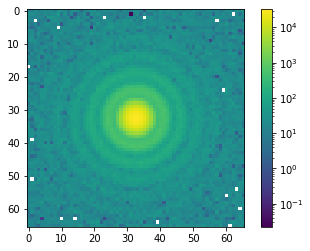

In [12]:
plt.imshow(stars[-1].array, norm=LogNorm())
plt.colorbar()

## Same spot varying foreground light

Text(0.5, 0, 'Foreground light [photons/cm^2]')

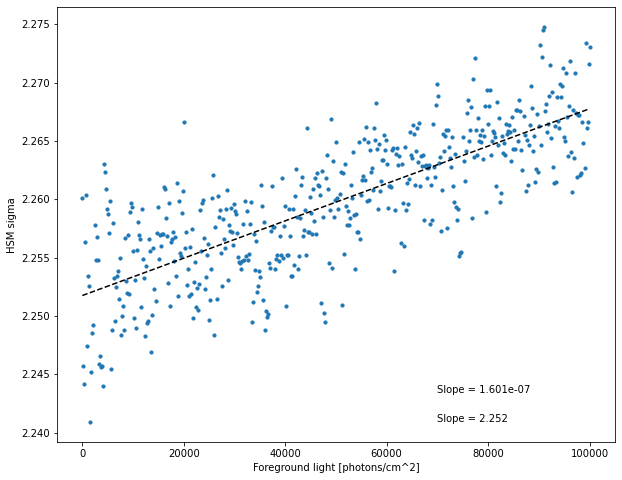

In [19]:
f,ax = plt.subplots(1,1, figsize=(10,8))

color = cm.rainbow(np.linspace(0, 1, 10))
stars = []
for count, j in enumerate(np.linspace(0,100000,500)):

    # random seed
    rng = galsim.BaseDeviate(i)

    # add 9.0 microns sigma of Gaussian to model diffusion
    # convert 9.0 microns to arcsec with factor 0.2"/10micron 
    pixscale = 0.2/10.e-6
    dprof = galsim.Gaussian(sigma=9.0e-6*pixscale)

    # Airy function to simulate diffraction through mask
    # Calculated from ~1000nm light and estimated distance to mask to match observed spots
    lam_over_diam = 0.00000491  # radians
    lam_over_diam *= 206265  # Convert to arcsec
    airy = galsim.Airy(lam_over_diam)

    # add shear term (optional)
    sprof = galsim.Shear(g1=0.05, g2=0.03)

    # add foreground light in photons/cm^2/s
    fprof = galsim.Box(66,66,flux=j)

    # convolve these terms
    prof = galsim.Convolve([dprof,airy]).withFlux(8000.)
    prof = galsim.Add([prof,fprof])

    # draw image
    blank_image = galsim.Image(66,66,scale=0.2,xmin=0,ymin=0,dtype=np.float64)  
    star_image = prof.drawImage(image=blank_image,method='sb')

    # generate noise and add to image
    noise = galsim.CCDNoise(rng, gain=1.5, read_noise=11.3, sky_level=0.0)
    star_image.addNoise(noise)

    stars.append(star_image)

# generate multiple stars with different noise levels
moments_sigma = [] # sigma
moments_amp = [] # flux
observed_shape = [] # shear
moments_centroid = [] # centroid
peak_signal = [] # peak_signal
read_noise = [] # added CCD Noise
foreground_light = np.linspace(0,100000,500) # added foreground profile

for i,star in enumerate(stars):
    # calculate HSM moments (these are in pixel coordinates) for each star
    mom = star.FindAdaptiveMom(weight=None, strict=False)
    moments_sigma.append(mom.moments_sigma)
    moments_amp.append(mom.moments_amp)
    observed_shape.append(mom.observed_shape.shear)
    moments_centroid.append(mom.moments_centroid)
    peak_signal.append(np.max(stars[i].array))
    read_noise.append(11.3)


# plot it
im = ax.scatter(foreground_light,moments_sigma,s=10)
m,b = np.polyfit(foreground_light,moments_sigma,deg=1)
plt.plot([0,100000], [(0*m) + b, (100000*m) + b], "k--")
plt.text(70000, np.min(moments_sigma)+.0025, "Slope = " + str(round(m,10)))
plt.text(70000, np.min(moments_sigma), "Slope = " + str(round(b,3)))
plt.ylabel("HSM sigma")
plt.xlabel("Foreground light [photons/cm^2]")
